In [80]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pyranges as pr
import itertools
from collections import defaultdict
import os
import glob
import sys
sys.path.append("/Genomics/kocherlab/bjarnold/STARRseq/code/notebooks")
import functions as fn



In [81]:
# species with ATAC data
SPECIES_LIST = sorted(['Amel', 'Apur', 'Aaur'])
min_biorep_support=3
fold_diff_thresh=2
MACS_peaks_data_dir = f'/Genomics/kocherlab/bjarnold/STARRseq/data/ATAC_MACS_peaks_overlap/MACS_peaks/min_biorep_support_{min_biorep_support}/qval_0_folddiff_{fold_diff_thresh}'

# ATAC data
ATAC_qval_threshold = 1.3 # 1.3 corresponds to pvalue of 0.05, 1 corresponds to pvalue of 0.1
ATAC_folddiff_threshold = 0
ATAC_data_dir = '/Genomics/kocherlab/bmjones/ATACseq/Nikki_pilot'
ATAC_data = defaultdict(str)
ATAC_data['Amel'] = f'{ATAC_data_dir}/AMEL/MACS2/2312__H1_10__ATACseq-testrun_peaks.narrowPeak'
ATAC_data['Apur'] = f'{ATAC_data_dir}/APUR/MACS2/2312__P2_2__ATACseq-testrun_peaks.narrowPeak'
ATAC_data['Aaur'] = f'{ATAC_data_dir}/AAUR/MACS2/2312__Big__ATACseq-testrun_peaks.narrowPeak'

frac_overlap = 0

In [82]:
# load in peak calling results
MACS_raw_dfs, MACS_dedup_dfs  = [], []
for s in SPECIES_LIST:
    # load MACS peaks
    raw = pd.read_csv(f'{MACS_peaks_data_dir}/{s}/MACS2_peaks_raw.tsv', sep='\t')
    dedup = pd.read_csv(f'{MACS_peaks_data_dir}/{s}/MACS2_peaks_dedup.tsv', sep='\t')
    
    raw = raw[['Chromosome', 'Start', 'End']]
    dedup = dedup[['Chromosome', 'Start', 'End']]

    MACS_raw_dfs.append(raw)
    MACS_dedup_dfs.append(dedup)
    
ATAC_dfs = fn.load_peak_caller_results([ATAC_data[s] for s in SPECIES_LIST])
ATAC_dfs = fn.filter_by_sig_effect_size(ATAC_dfs, ATAC_qval_threshold, ATAC_folddiff_threshold)


MACS_raw_prs = [pr.PyRanges(m) for m in MACS_raw_dfs]
MACS_dedup_prs = [pr.PyRanges(m) for m in MACS_dedup_dfs]
ATAC_prs = [pr.PyRanges(m) for m in ATAC_dfs]

before filtering: 1838
after filtering: 1838
before filtering: 277
after filtering: 277
before filtering: 1362
after filtering: 1362


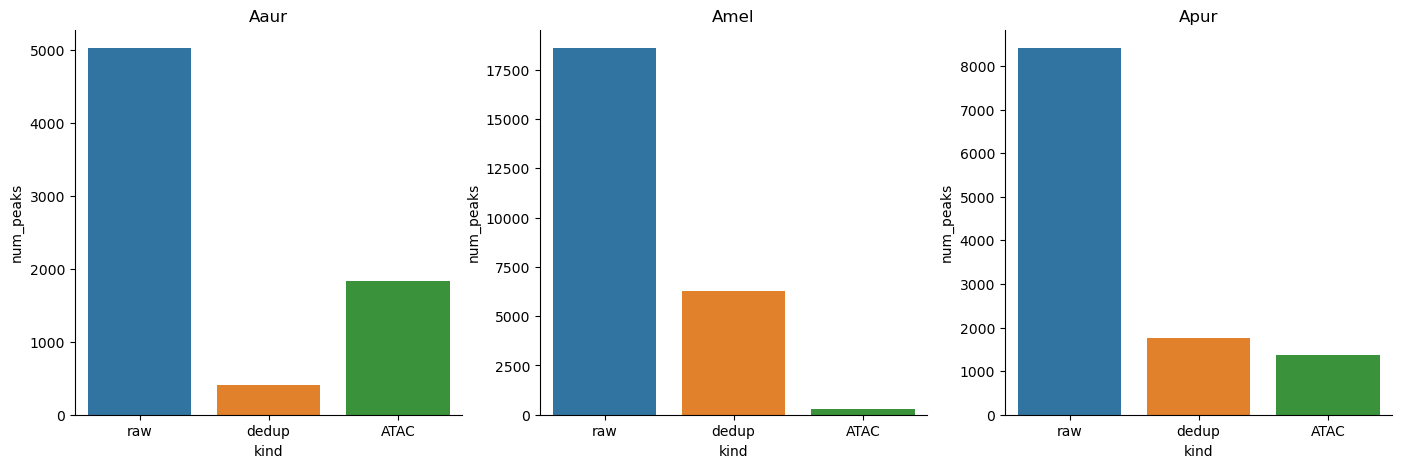

In [83]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
for i, s in enumerate(SPECIES_LIST):
    num_peaks = [len(MACS_raw_dfs[i]), len(MACS_dedup_dfs[i]), len(ATAC_dfs[i])]
    kind = ["raw", "dedup", "ATAC"]
    d = pd.DataFrame({"num_peaks": num_peaks, "kind": kind})
    # print(d)
    sns.barplot(data=d, x='kind', y='num_peaks', ax=axs[i])
    axs[i].set_title(s)
sns.despine()


In [84]:
ATAC_raw_coverages_dfs, ATAC_dedup_coverages_dfs = [], []
for raw,dedup,atac in zip(MACS_raw_prs, MACS_dedup_prs, ATAC_prs):
    raw_cov = atac.coverage(raw, overlap_col="C", fraction_col="F").df
    raw_cov = raw_cov[(raw_cov['C']>=1) & (raw_cov['F']>frac_overlap)]
    raw_cov.reset_index(inplace=True, drop=True)

    dedup_cov = atac.coverage(dedup, overlap_col="C", fraction_col="F").df
    dedup_cov = dedup_cov[(dedup_cov['C']>=1) & (dedup_cov['F']>frac_overlap)]
    dedup_cov.reset_index(inplace=True, drop=True)

    ATAC_raw_coverages_dfs.append(raw_cov)
    ATAC_dedup_coverages_dfs.append(dedup_cov)    


In [85]:
ATAC_overlap_raw = []
ATAC_overlap_dedup = []

print("RAW DATA")

for s,atac_df,raw_cov, in zip(SPECIES_LIST, ATAC_dfs, ATAC_raw_coverages_dfs):
    print(s)
    print(f'atac_total: {len(atac_df)}')
    print(f'raw_cov: {len(raw_cov)}')
    print("ratio:", len(raw_cov)/len(atac_df))
    print()
    ATAC_overlap_raw.append(len(raw_cov)/len(atac_df))

print("DEDUPLICATED DATA")

for s,atac_df,dedup_cov, in zip(SPECIES_LIST, ATAC_dfs, ATAC_dedup_coverages_dfs):
    print(s)
    print(f'atac_total: {len(atac_df)}')
    print(f'dedup_cov: {len(dedup_cov)}')
    print("ratio:", len(dedup_cov)/len(atac_df))
    print()
    ATAC_overlap_dedup.append(len(dedup_cov)/len(atac_df))

RAW DATA
Aaur
atac_total: 1838
raw_cov: 14
ratio: 0.007616974972796518

Amel
atac_total: 277
raw_cov: 41
ratio: 0.148014440433213

Apur
atac_total: 1362
raw_cov: 7
ratio: 0.005139500734214391

DEDUPLICATED DATA
Aaur
atac_total: 1838
dedup_cov: 4
ratio: 0.002176278563656148

Amel
atac_total: 277
dedup_cov: 93
ratio: 0.33574007220216606

Apur
atac_total: 1362
dedup_cov: 1
ratio: 0.0007342143906020558



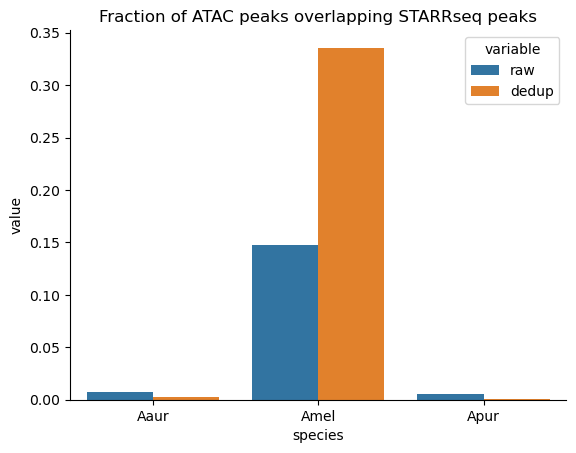

In [86]:
d = pd.DataFrame.from_dict({"species": SPECIES_LIST, 
                  "raw": ATAC_overlap_raw, 
                  "dedup": ATAC_overlap_dedup})
d = d.melt(id_vars="species")
sns.barplot(data=d, x="species", y="value", hue="variable") 
plt.title("Fraction of ATAC peaks overlapping STARRseq peaks")
sns.despine()

In [87]:
raw_coverages_dfs, dedup_coverages_dfs = [], []
for raw,dedup,atac in zip(MACS_raw_prs, MACS_dedup_prs, ATAC_prs):
    raw_cov = raw.coverage(atac, overlap_col="C", fraction_col="F").df
    raw_cov = raw_cov[(raw_cov['C']>=1) & (raw_cov['F']>frac_overlap)]
    raw_cov.reset_index(inplace=True, drop=True)

    dedup_cov = dedup.coverage(atac, overlap_col="C", fraction_col="F").df
    dedup_cov = dedup_cov[(dedup_cov['C']>=1) & (dedup_cov['F']>frac_overlap)]
    dedup_cov.reset_index(inplace=True, drop=True)

    raw_coverages_dfs.append(raw_cov)
    dedup_coverages_dfs.append(dedup_cov)

In [88]:
raw_overlap_ATAC = []
dedup_overlap_ATAC = []

print("RAW DATA")

for s,raw_df,raw_cov, in zip(SPECIES_LIST, MACS_raw_dfs, raw_coverages_dfs):
    print(s)
    print(f'raw_total: {len(raw_df)}')
    print(f'raw_cov: {len(raw_cov)}')
    print("ratio:", len(raw_cov)/len(raw_df))
    print()
    raw_overlap_ATAC.append(len(raw_cov)/len(raw_df))

print("DEDUPLICATED DATA")

for s,dedup_df,dedup_cov, in zip(SPECIES_LIST, MACS_dedup_dfs, dedup_coverages_dfs):
    print(s)
    print(f'dedup_total: {len(dedup_df)}')
    print(f'dedup_cov: {len(dedup_cov)}')
    print("ratio:", len(dedup_cov)/len(dedup_df))
    print()
    dedup_overlap_ATAC.append(len(dedup_cov)/len(dedup_df))

RAW DATA
Aaur
raw_total: 5026
raw_cov: 14
ratio: 0.002785515320334262

Amel
raw_total: 18597
raw_cov: 37
ratio: 0.001989568209926332

Apur
raw_total: 8412
raw_cov: 7
ratio: 0.0008321445553970519

DEDUPLICATED DATA
Aaur
dedup_total: 413
dedup_cov: 4
ratio: 0.009685230024213076

Amel
dedup_total: 6297
dedup_cov: 72
ratio: 0.011434016198189614

Apur
dedup_total: 1771
dedup_cov: 1
ratio: 0.000564652738565782



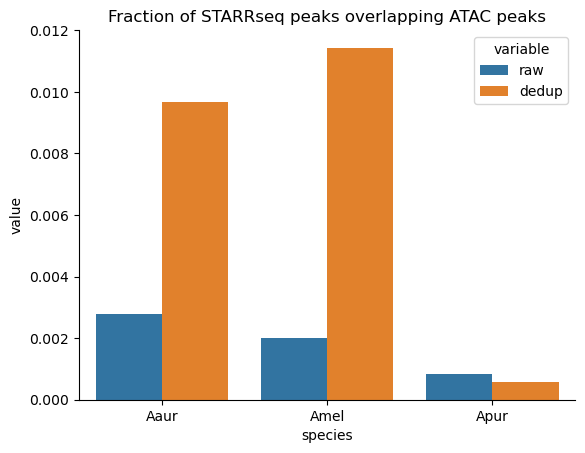

In [89]:
d = pd.DataFrame.from_dict({"species": SPECIES_LIST, 
                  "raw": raw_overlap_ATAC, 
                  "dedup": dedup_overlap_ATAC})
d = d.melt(id_vars="species")
sns.barplot(data=d, x="species", y="value", hue="variable") 
plt.title("Fraction of STARRseq peaks overlapping ATAC peaks")
sns.despine()

In [90]:
ATAC_overlap_raw = []
ATAC_overlap_dedup = []

print("RAW DATA")

for s,atac_df,raw_cov, in zip(SPECIES_LIST, ATAC_dfs, raw_coverages_dfs):
    print(s)
    print(f'atac_total: {len(atac_df)}')
    print(f'raw_cov: {len(raw_cov)}')
    print("ratio:", len(raw_cov)/len(atac_df))
    print()
    ATAC_overlap_raw.append(len(raw_cov)/len(atac_df))

print("DEDUPLICATED DATA")

for s,atac_df,dedup_cov, in zip(SPECIES_LIST, ATAC_dfs, dedup_coverages_dfs):
    print(s)
    print(f'atac_total: {len(atac_df)}')
    print(f'dedup_cov: {len(dedup_cov)}')
    print("ratio:", len(dedup_cov)/len(atac_df))
    print()

RAW DATA
Aaur
atac_total: 1838
raw_cov: 14
ratio: 0.007616974972796518

Amel
atac_total: 277
raw_cov: 37
ratio: 0.13357400722021662

Apur
atac_total: 1362
raw_cov: 7
ratio: 0.005139500734214391

DEDUPLICATED DATA
Aaur
atac_total: 1838
dedup_cov: 4
ratio: 0.002176278563656148

Amel
atac_total: 277
dedup_cov: 72
ratio: 0.259927797833935

Apur
atac_total: 1362
dedup_cov: 1
ratio: 0.0007342143906020558



In [91]:
len(MACS_raw_prs[0])

5026